In [50]:
import pickle
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sys.path.append(".")

from itertools import product
from pathlib import Path
from typing import Tuple, Dict, NewType, List

In [51]:
def get_runs(path: str):
    return [x for x in os.listdir(path) if "run" in x]

Figure = NewType('Figure', matplotlib.figure.Figure)
Axis   = NewType('Figure', matplotlib.axes.Axes)

def heat_plot(X: np.array, size: Tuple[int] = None,
              x_tick_labels: List[str] = None,
              y_tick_labels: List[str] = None,
              cmap: str = None,
              cbar: bool = False,
              fig: Figure = None,
              ax: Axis = None) -> Tuple[Figure, Axis]:
    if fig == None and ax == None:
        fig, ax = plt.subplots(1, 1)
        if size != None:
            fig.set_size_inches(size)
        else:
            fig.set_size_inches(w = 15, h = 10)
    
    sns.heatmap(X, linewidth = 0, ax = ax, cmap = cmap, cbar = cbar)
    
    ax.locator_params('x', nbins = 3)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    if x_tick_labels != None:
        ax.set_xticklabels(x_tick_labels)
    if y_tick_labels != None:
        ax.set_yticklabels(y_tick_labels)
    
    return fig, ax

def get_mean_stats(param_list: Dict, results_path: str, T: int) -> Dict:
    mean_stats = {}
        
    for param in product(*param_list.values()):
        input_path = Path(results_path) / str(param)
        try:
            runs = get_runs(input_path)
        except:
            continue
        
        mean_run_stats = {
            "Entropy": np.zeros(T),
            "Proximity": np.zeros(T),
            "Polarity": np.zeros(T),
            "Distribution": np.zeros((32, T))
        }
        
        num_runs = len(runs)
        
        for run in runs:
            stats = pickle.load(open(input_path / run, "rb"))
            mean_run_stats['Entropy'] += stats['Entropy']
            mean_run_stats['Proximity'] += stats['Proximity']
            mean_run_stats['Polarity'] += stats['Polarity']
            mean_run_stats['Distribution'] += np.array(stats['Distribution']).T
            
        mean_run_stats['Entropy'] /= num_runs
        mean_run_stats['Proximity'] /= num_runs
        mean_run_stats['Polarity'] /= num_runs
        mean_run_stats['Distribution'] /= num_runs
        
        mean_stats[param] = mean_run_stats
        
    return mean_stats

In [52]:
# Experiment's setup

param_list = {
    "graph_type": ["barabasi"],
    "network_size": [500],
    "memory_size": [160],
    "code_length": [5],
    "kappa": [0, 15, 30],
    "lambda": [0, 0.1, 0.3, 1, 5],
    "alpha": [1, 0.8, 0.6, 0.5, 0.4, 0.2],
    "omega": [0, 0.2, 0.4, 0.5, 0.6, 0.8],
    "gamma": [-10, 0, 10],
    "prefferential_att": [2]
}

experiment_path =  "/media/roboto/Tranqueiras/entropia_grafos_experimentos/experiment_barabasi_with_polarization"

simulated_params = [x for x in os.listdir(experiment_path) if '(' in x]

In [53]:
mean_stats = get_mean_stats(param_list, experiment_path, T = 500)

In [54]:
with open("mean_stats_barabasi_polarization.pkl", "wb") as file:
    pickle.dump(mean_stats, file)

In [6]:
mean_stats = pickle.load(open("mean_stats_barabasi_polarization.pkl", "rb"))

***

### Cenário 1: Um único grupo polarizado.

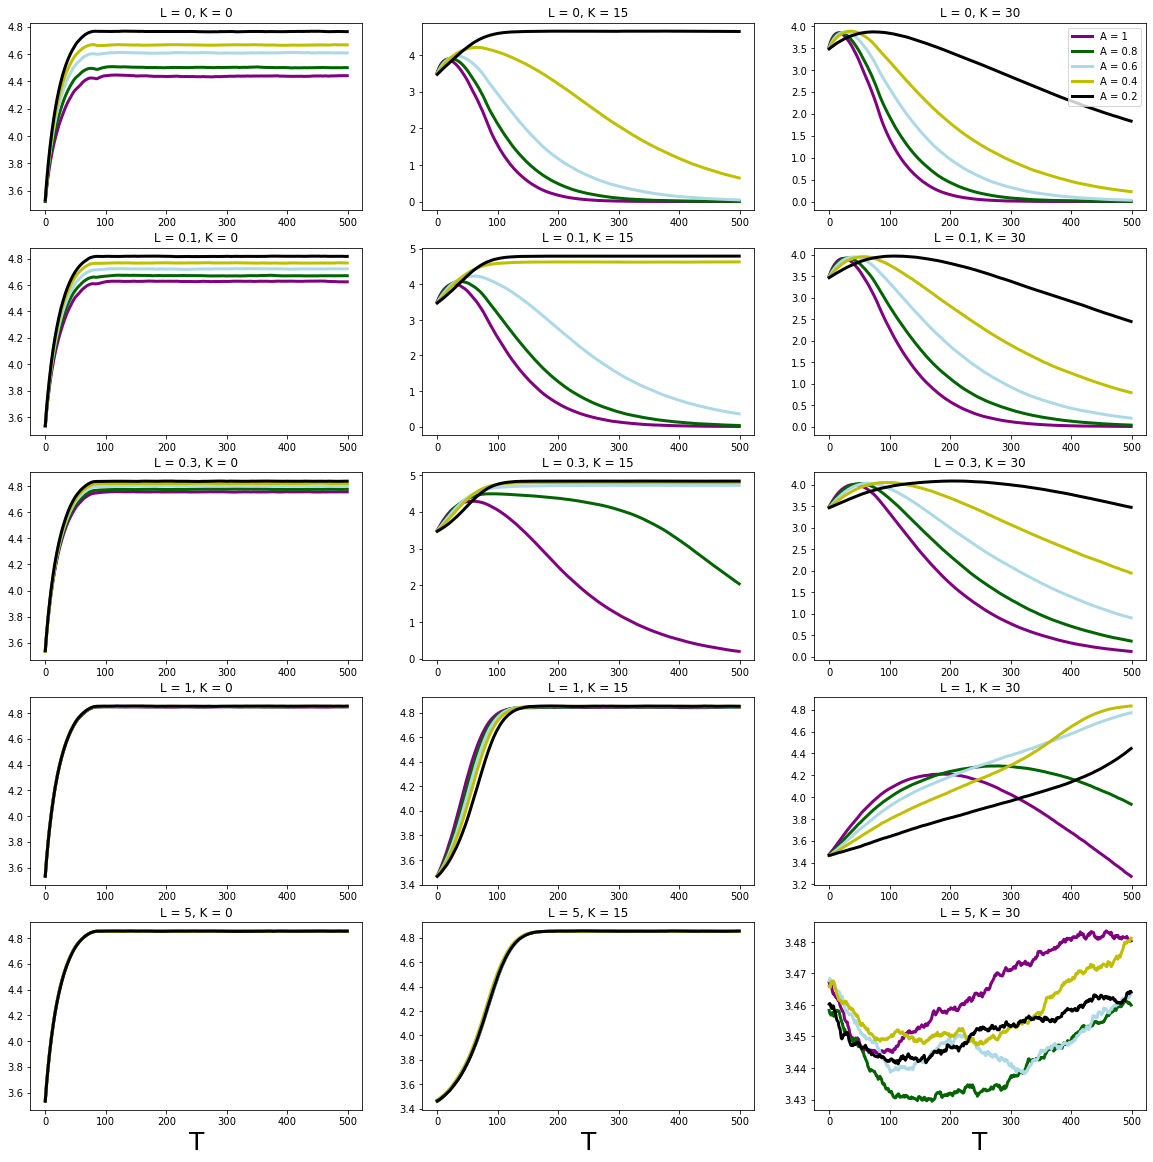

In [23]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

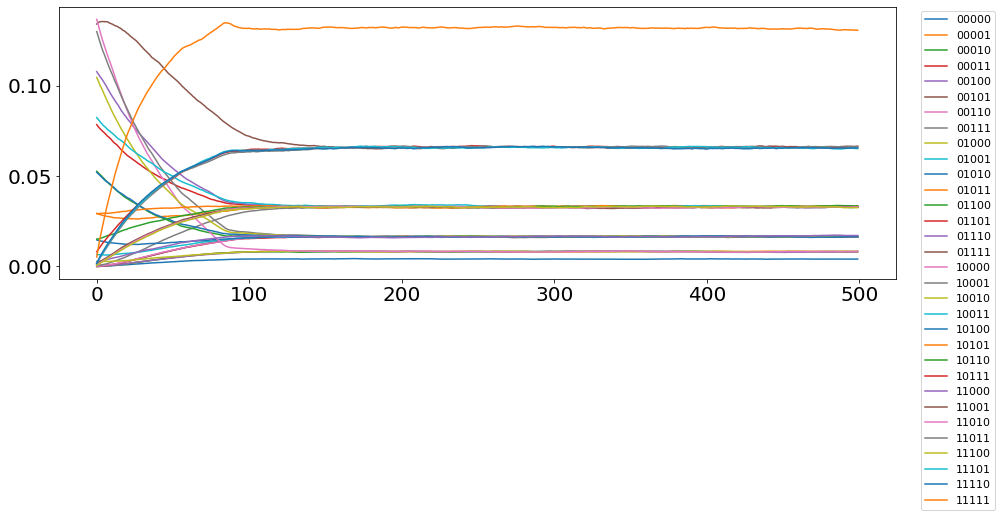

In [26]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0
kappa = 0
alpha = 1

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

Text(0.5, 1.0, '$\\kappa = 15$ - $\\lambda = 0.3$ - $\\alpha = 1$')

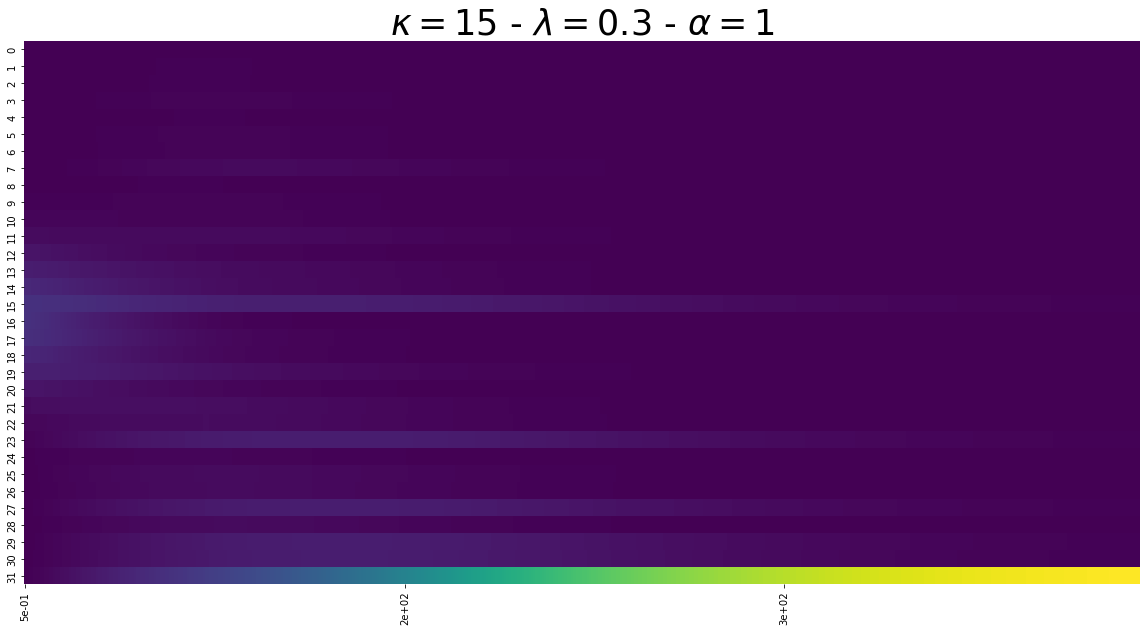

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.subplots_adjust(wspace = 0.05)

lambd = 0.3
kappa = 15
alpha = 1

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, 0, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax)
ax.set_title(r"$\kappa = 15$ - $\lambda = 0.3$ - $\alpha = 1$", fontsize = 35)

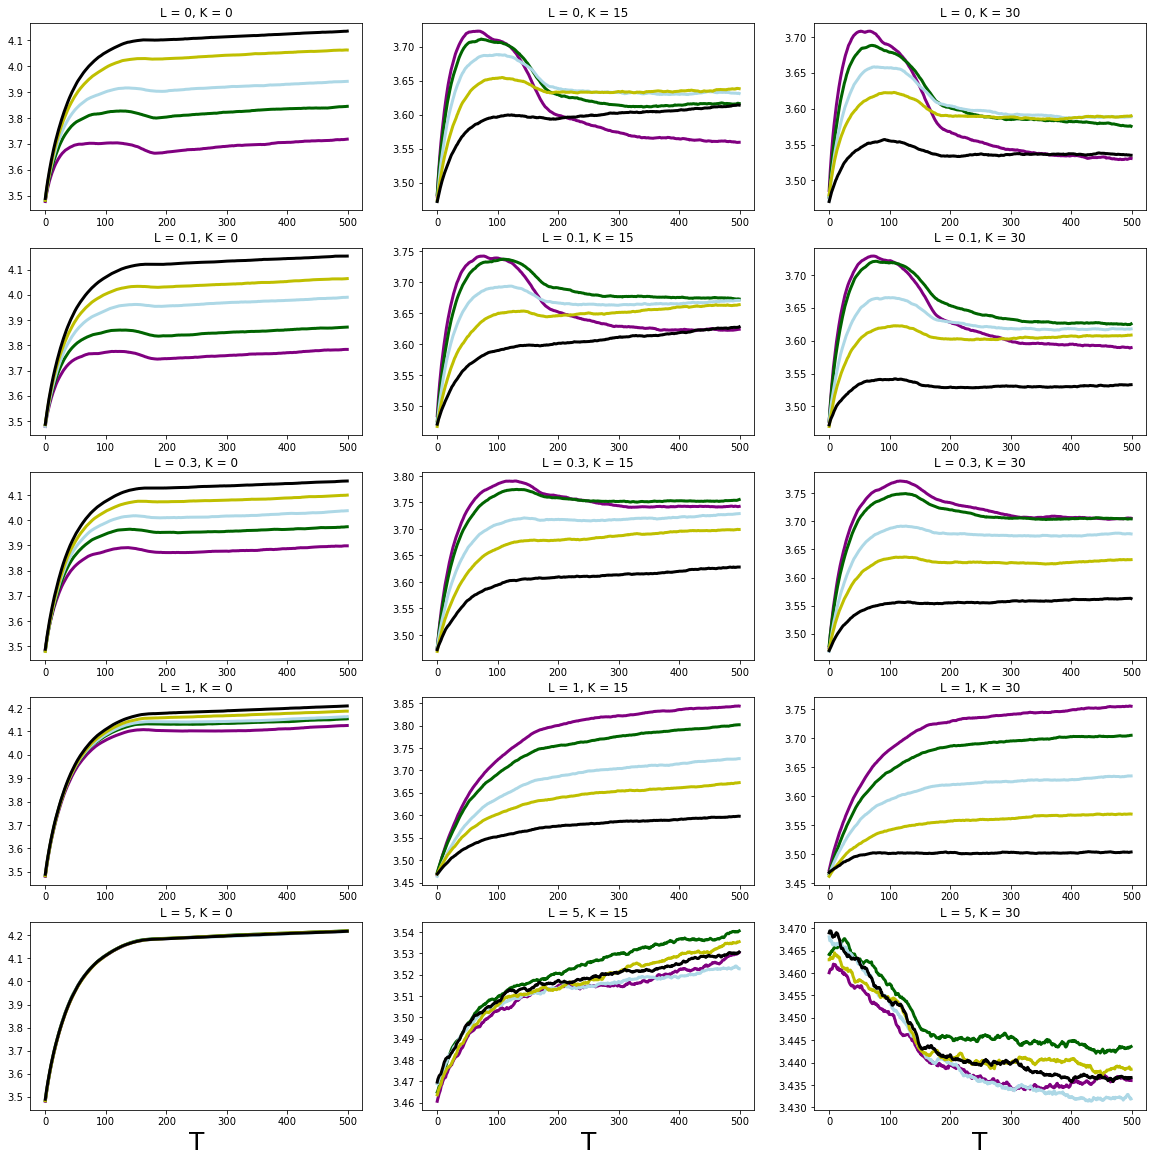

In [8]:
#### Gamma Negativo

fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, -10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")

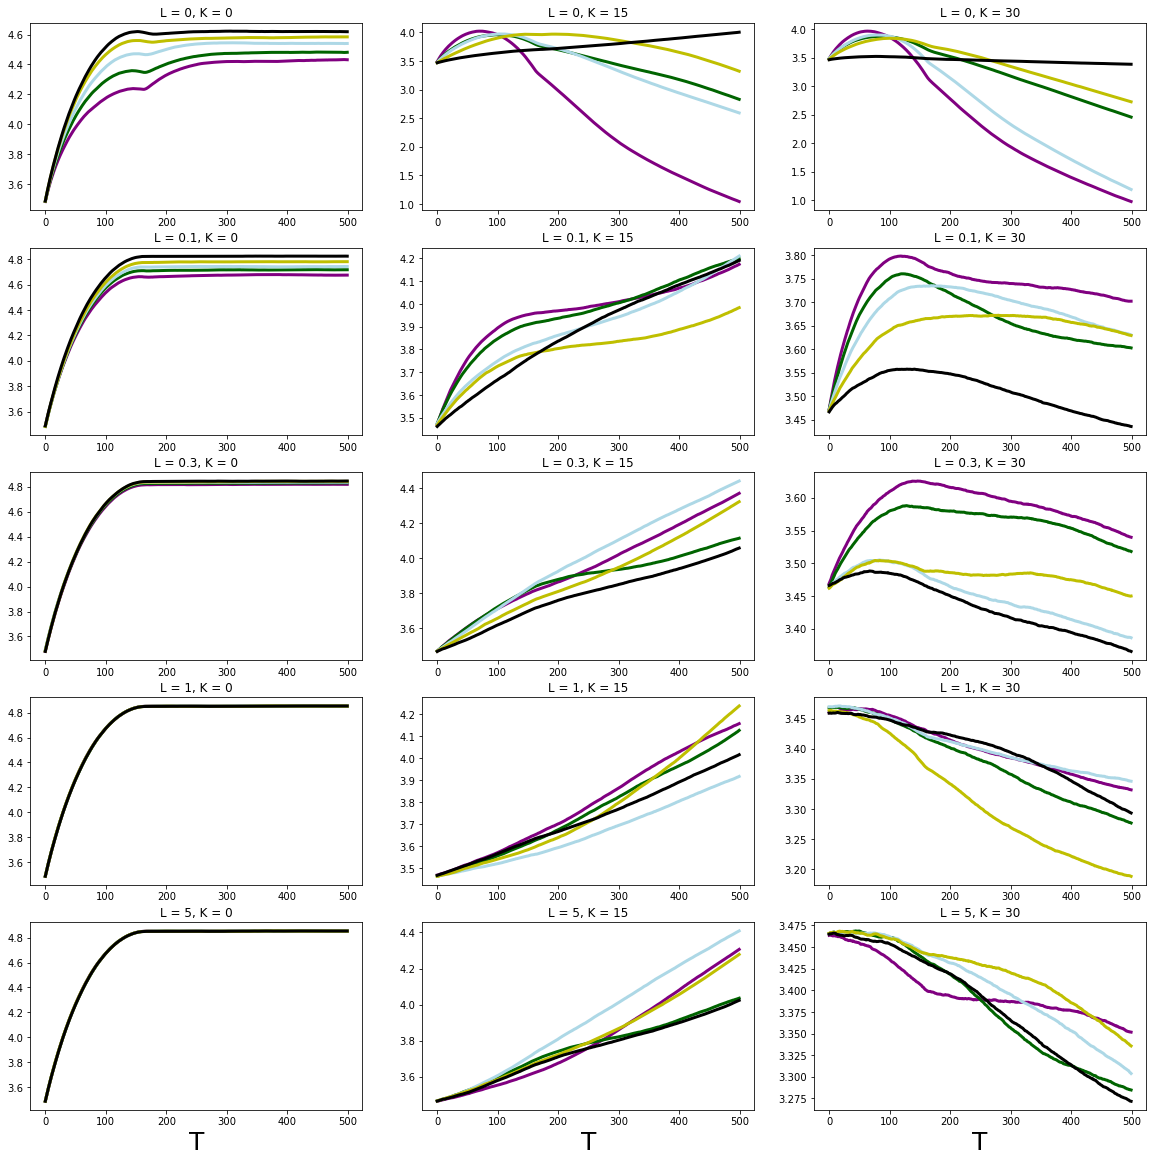

In [22]:
### Gamma Positivo

fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, 10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")

### Cenário 2 - Dois grupos polarizados, um neutro.

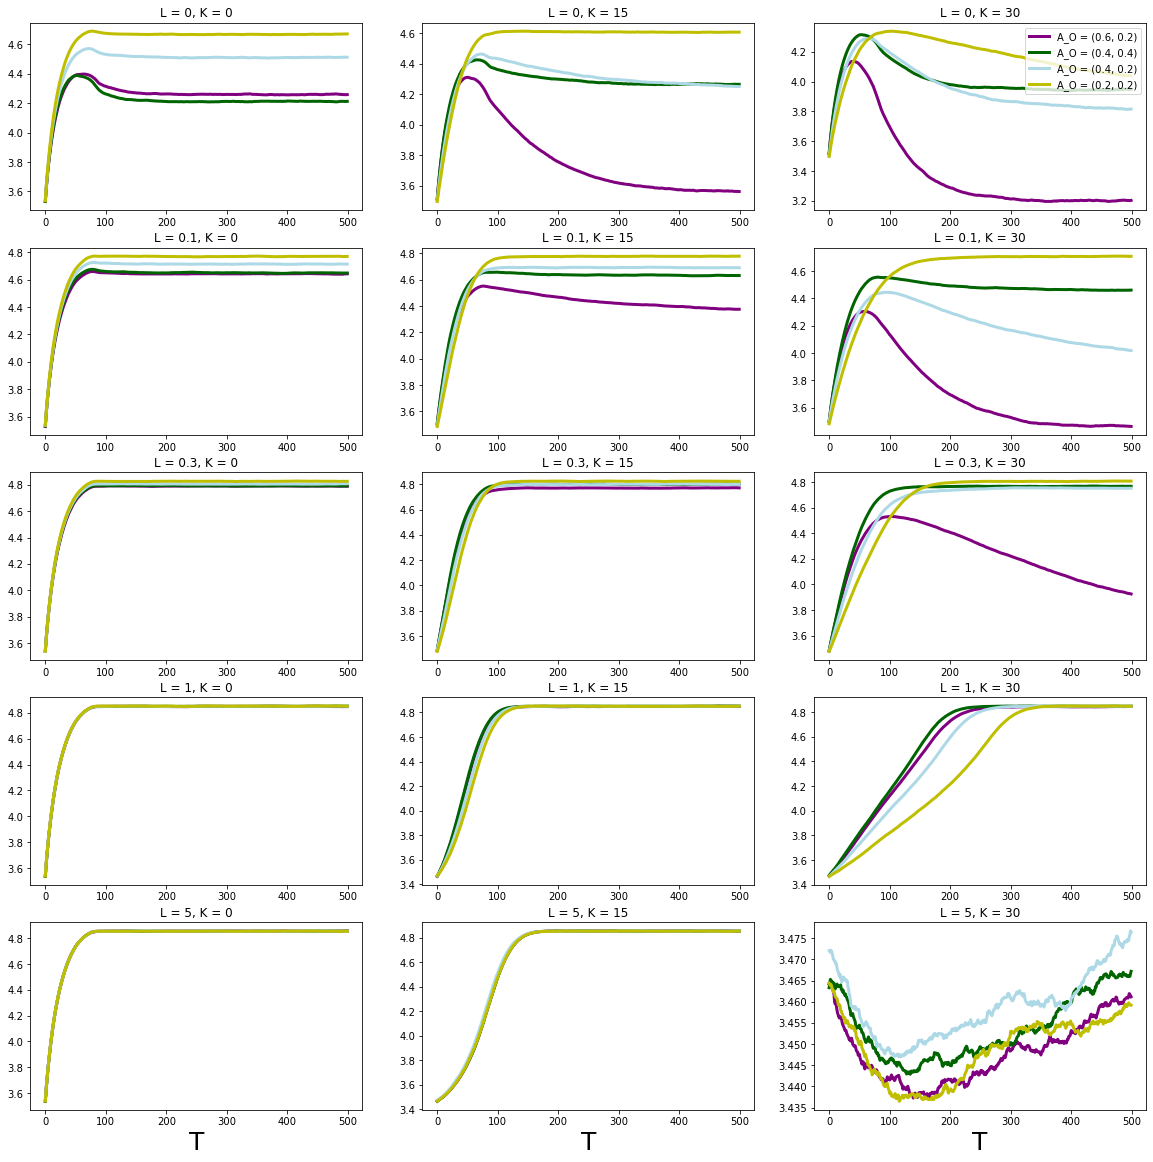

In [57]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

Text(0.5, 1.0, '$\\kappa = 15$ - $\\lambda = 0.3$ - $\\alpha = 1$')

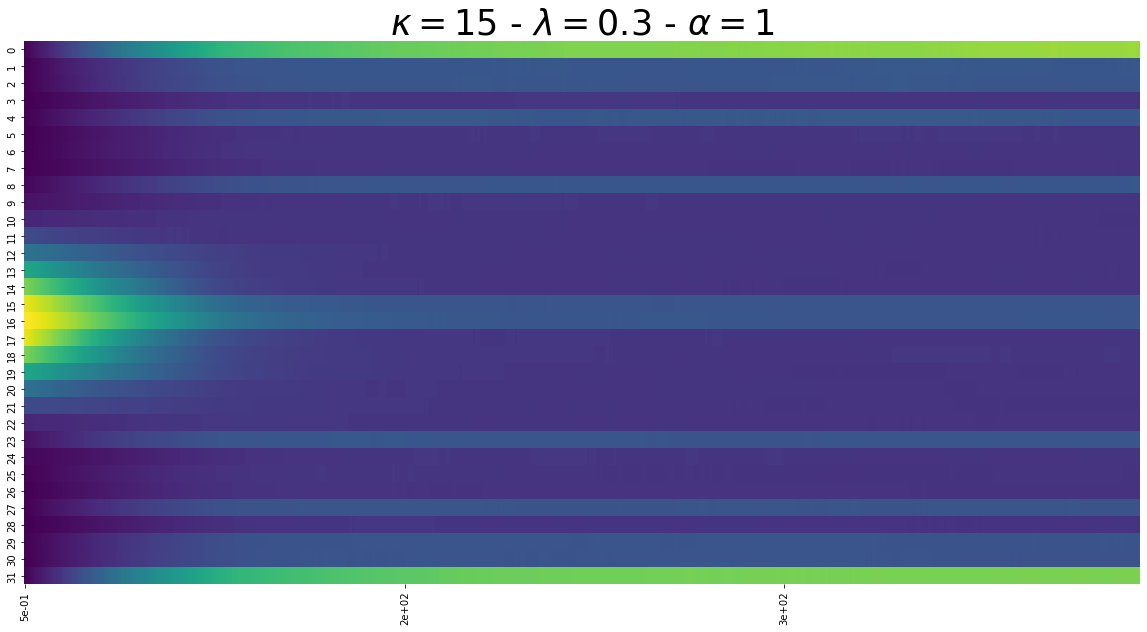

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.subplots_adjust(wspace = 0.05)

lambd = 0.1
kappa = 30
alpha = 0.4
omega = 0.4

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax)
ax.set_title(r"$\kappa = 15$ - $\lambda = 0.3$ - $\alpha = 1$", fontsize = 35)

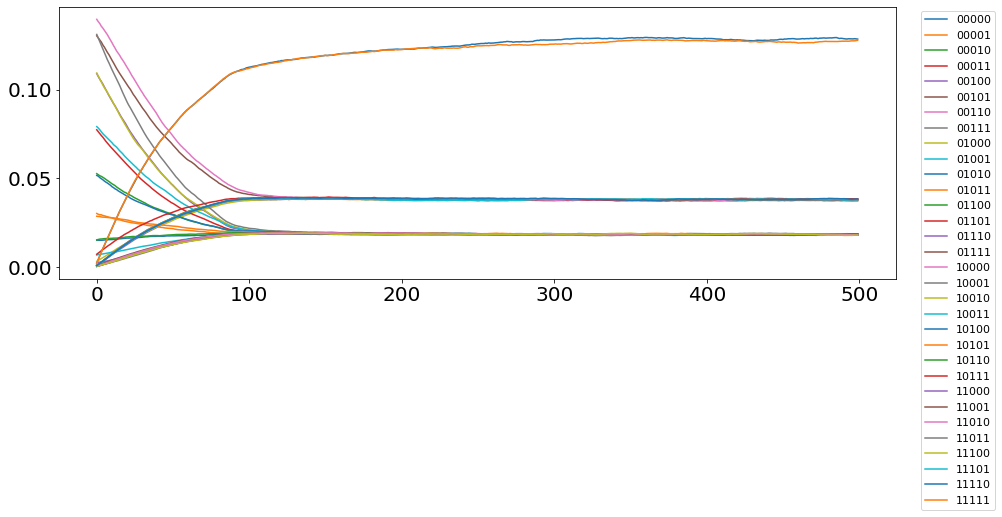

In [28]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0
kappa = 15
alpha = 0.4
omega = 0.4

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

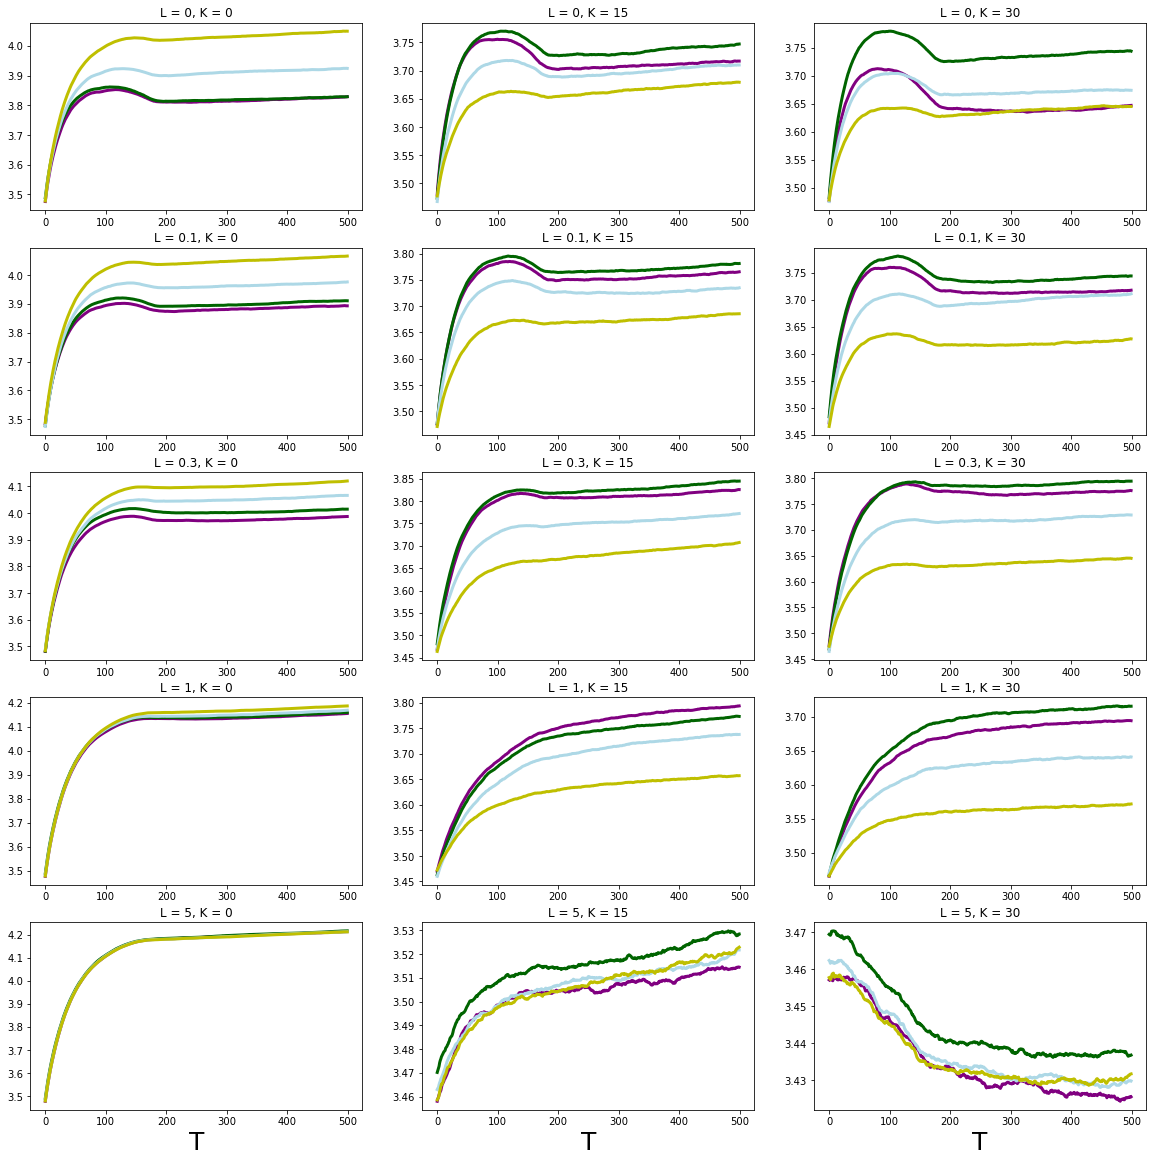

In [26]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], -10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")

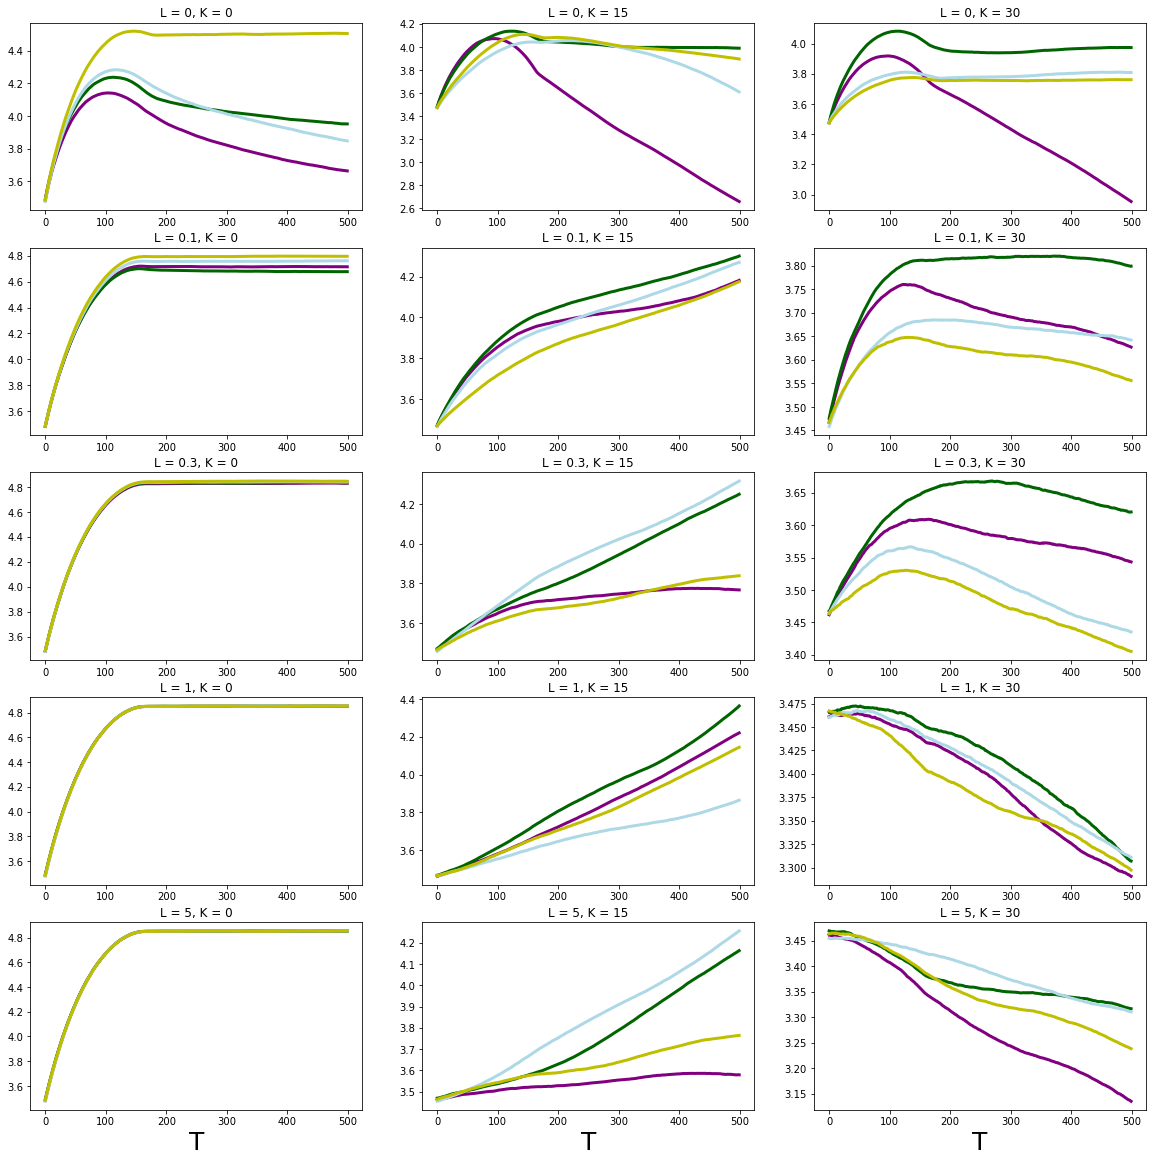

In [27]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")

### Cenário 3 - Dois grupos polarizados.

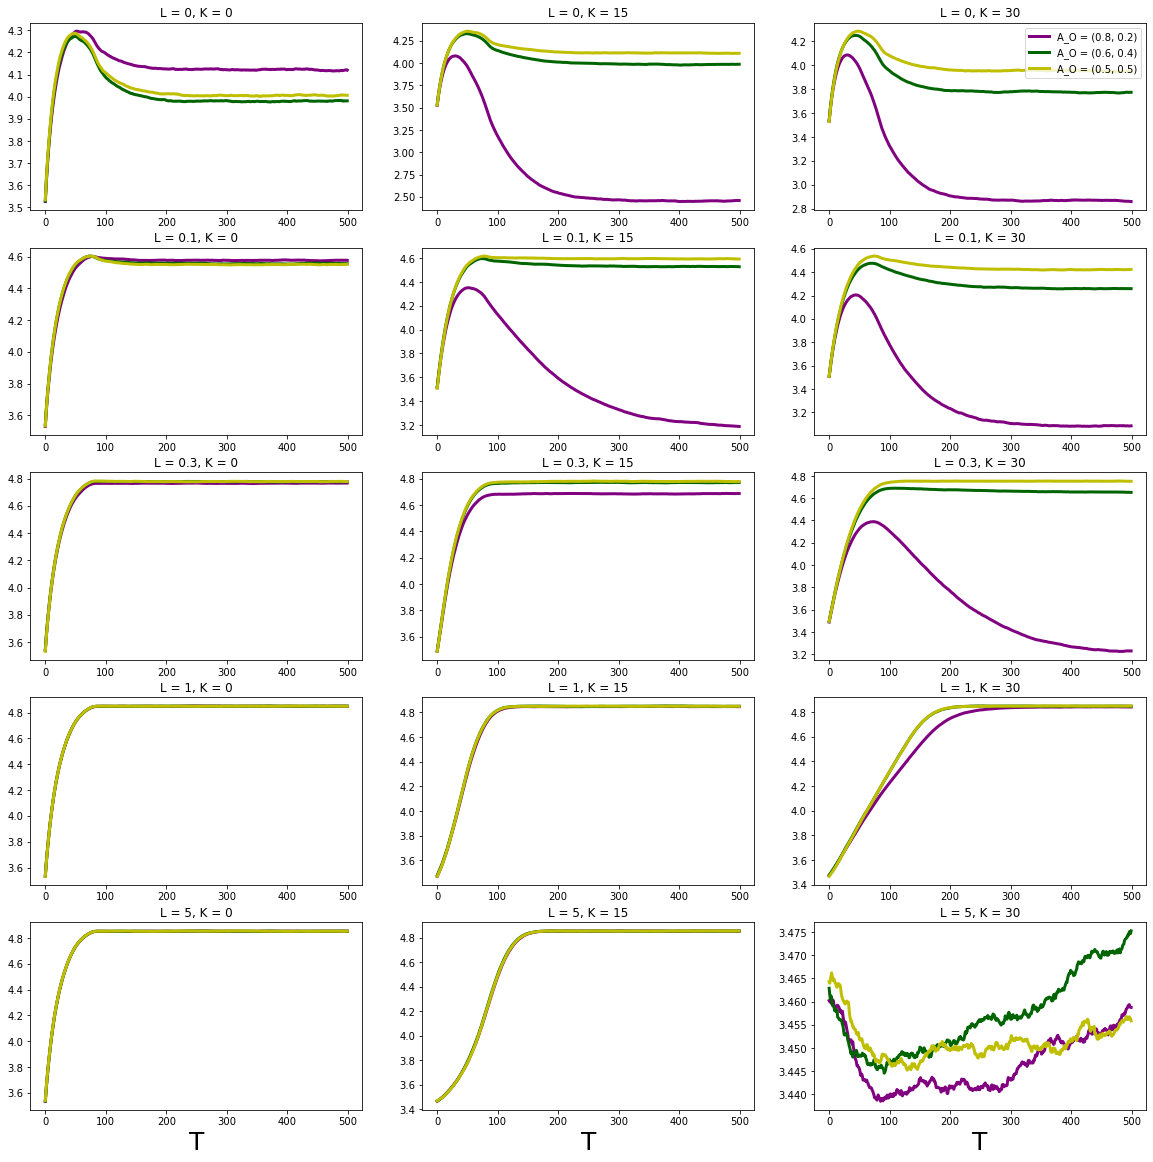

In [56]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

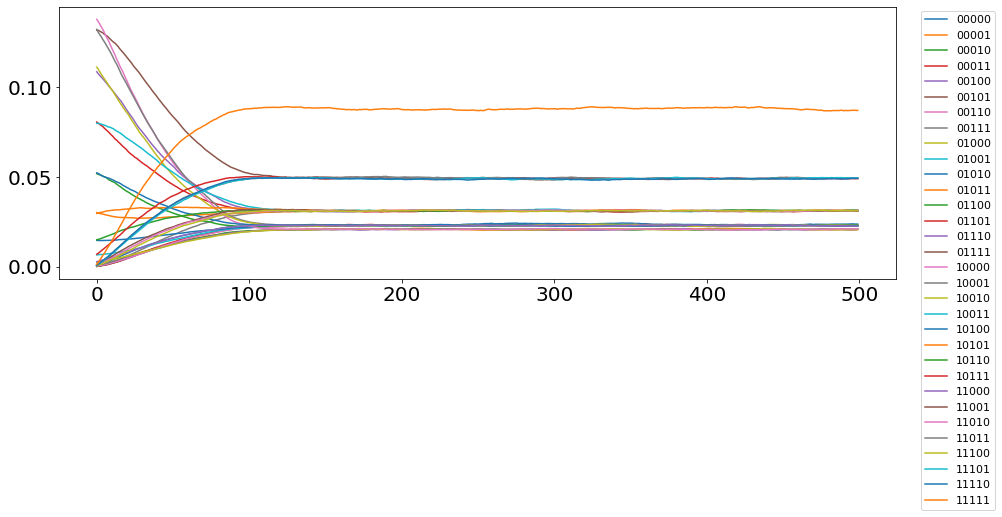

In [49]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0.3
kappa = 15
alpha = 0.8
omega = 0.2

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

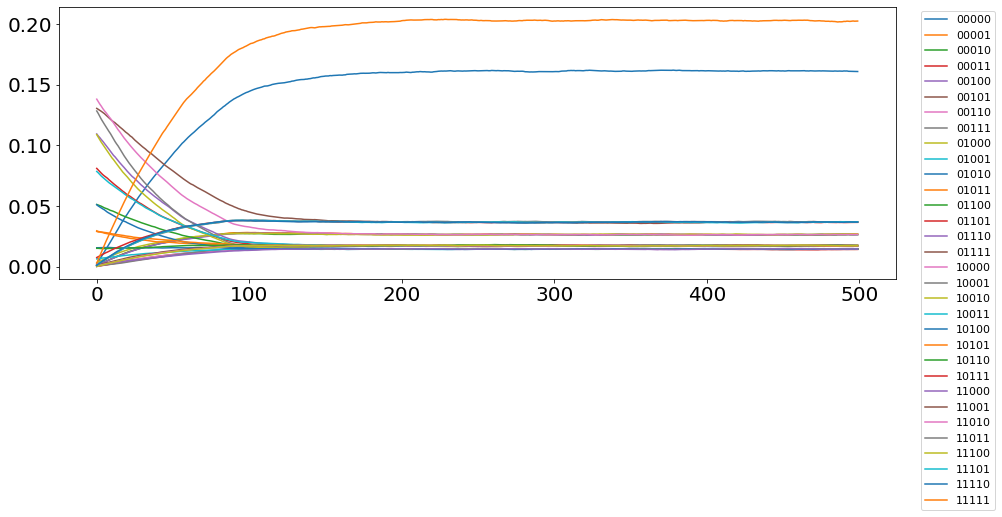

In [48]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0
kappa = 0
alpha = 0.6
omega = 0.4

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

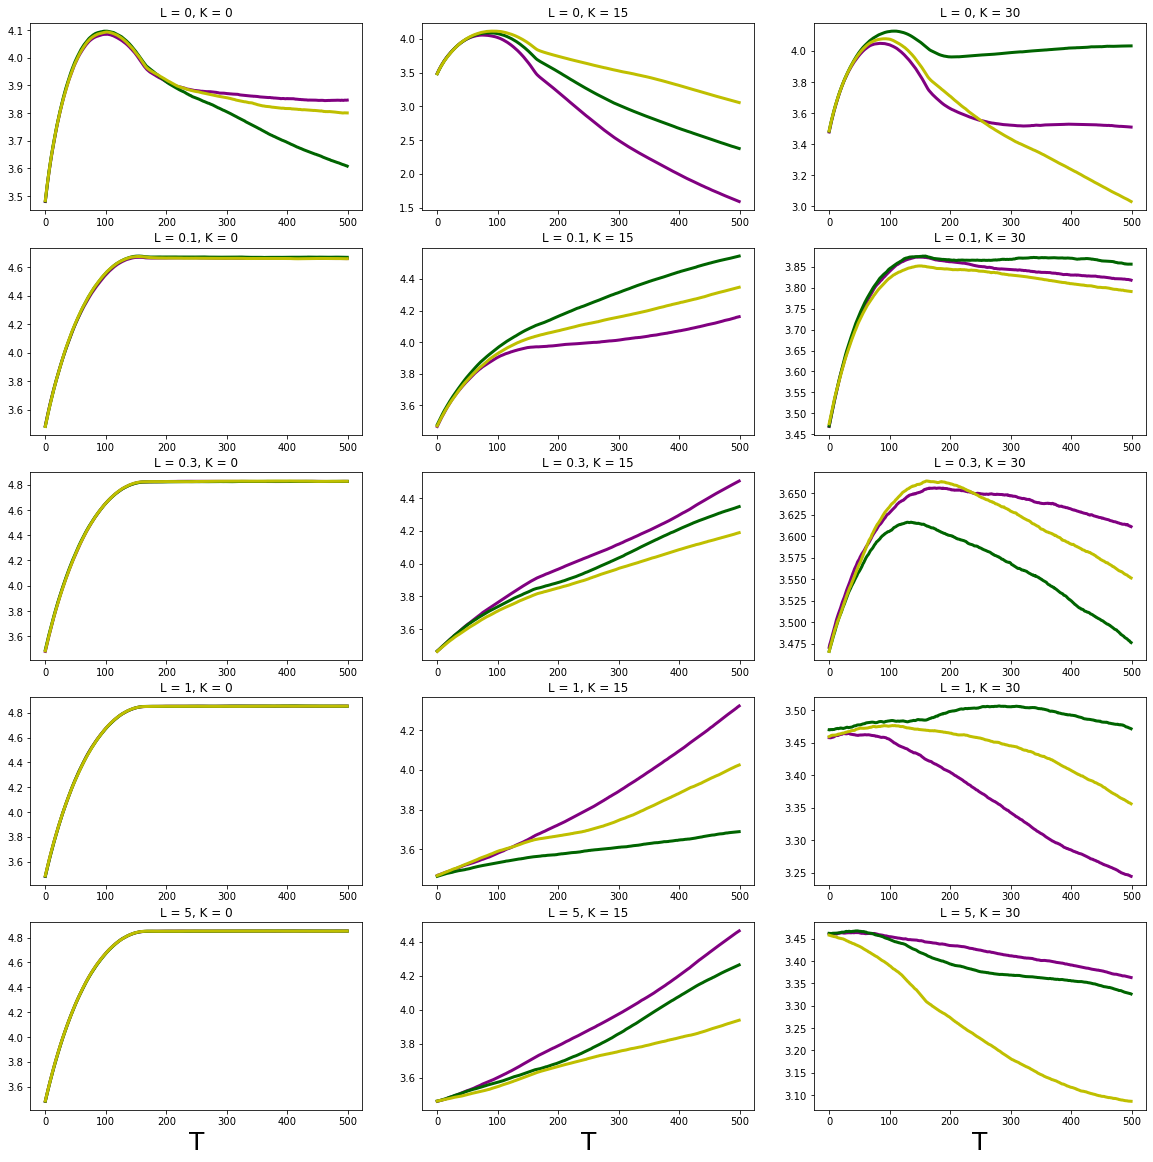

In [55]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")